# Markstein lengths from Cantera using Eq. (31)

Standalone notebook (no YAML configs). Uses a single-step H2/O2 reaction (Arrhenius parameters set below) and a 1D freely propagating flame to compute
Markstein lengths for curvature and strain as a function of non-dimensional temperature (T/Tu).

Equation (31) from Giannakopoulos et al. (Combustion and Flame 208, 2019):

$$
\bar{S}_d^{*} = S_L - L_{str}^{*} K_s - L_{cur}^{*} \kappa S_L
$$
$$
\begin{aligned}
L_{str}^{*} &= l_f \left[ \alpha \int_{1}^{\tilde{T}^{*}} \frac{\tilde{\lambda}(x)}{x}\,dx - \int_{\tilde{T}^{*}}^{\sigma} \frac{\tilde{\lambda}(x)}{x-1}\,dx \right] \\
L_{cur}^{*} &= l_f \left[ \alpha \int_{1}^{\tilde{T}^{*}} \frac{\tilde{\lambda}(x)}{x}\,dx \right]
\end{aligned}
$$

Here $\bar{S}_d^{*} = (\rho^{*}/\rho_u) S_d$ is the density-weighted displacement speed at the chosen isotherm, and
$\tilde{T}^{*} = T^{*}/T_u$. Also, $x = T/T_u$, $\tilde{\lambda} = \lambda/\lambda_u$, $\sigma = \rho_u/\rho_b$, and
$l_f = \lambda_u / (\rho_u c_{p,u} S_L)$. This notebook tabulates the dimensionless Markstein numbers
$L_{str}^{*}/l_f$ and $L_{cur}^{*}/l_f$.

The coefficient $\alpha$ is taken from Eq. (30):
$$
\begin{aligned}
L &= l_f \left[ \frac{\sigma}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x}\,dx + \frac{\beta}{2}\frac{Le_{\mathrm{eff}} - 1}{\sigma - 1}
\int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \ln\left(\frac{\sigma - 1}{x - 1}\right)\,dx \right] \\
&\equiv \alpha\,l_f
\end{aligned}
$$

Notes/assumptions:
- Set `USE_SUN_PARAMS` to true to apply Sun et al. (1999) values for H2-air (E=28.7 kcal/mol, LeF=0.33, LeO=2.32) and optionally force beta/sigma/l_f.
- Zel'dovich number uses the paper's definition: $\beta = E (T_a - T_u) / (R T_a^2)$, with $E$ set by `E_KCAL_MOL` in the single-step reaction (Kim et al. rate, Eq. (11)) ($T_a$ is taken as $T_{ad} = \max(T)$).
- $Le_{\mathrm{eff}}$ is computed from Eq. (27) using unburned Lewis numbers and reaction orders $a,b$ (set below). You can override $Le_F$/$Le_O$ with the fixed values from the paper (1.81/0.901) using `USE_FIXED_LEWIS`.
- When `CALIBRATE_RATE_A` is true, `RATE_A` (the pre-exponential $B$) is tuned per $\phi$ to match $S_L$ from the selected detailed mechanism (BurkeH2 for H2 or gri30 for propane) based on `USE_PROPANE`.


In [39]:
from pathlib import Path
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import pandas as pd
import cantera as ct

# ---------------------------
# User settings
# ---------------------------
PHI = 0.8

# Fuel/oxidizer toggle
USE_PROPANE = False
FUEL = 'C3H8' if USE_PROPANE else 'H2'
OXIDIZER = 'O2:1.0, N2:3.76'
REACTION_EQUATION = 'C3H8 + 5 O2 => 3 CO2 + 4 H2O' if USE_PROPANE else 'H2 + 0.5 O2 => H2O'
T_U = 298.0
P_U = ct.one_atm

# Global single-step reaction (Arrhenius parameters use Cantera units).
RATE_A = 1.0e12  # B in Eq. (11)
RATE_B = 0.0
E_KCAL_MOL = 40.2

# Sun et al. (1999) parameter toggle (H2-air, phi=0.81)
USE_SUN_PARAMS = True
SUN_E_KCAL_MOL = 28.7
SUN_LEWIS_FUEL = 0.33
SUN_LEWIS_OX = 2.32
SUN_FORCE_BETA = False
SUN_BETA = 5.7
SUN_FORCE_SIGMA = False
SUN_SIGMA = 0.0
SUN_FORCE_LF = False
SUN_LF_MM = 0.0

# Reaction orders for Eq. (27)
ORDER_A = 1.0
ORDER_B = 1.0

# Optional fixed Lewis numbers (paper uses LeF=1.81, LeO=0.901)
USE_FIXED_LEWIS = False
LEWIS_FUEL = 1.81
LEWIS_OX = 0.901

# Tune RATE_A to match detailed mechanism flame speed
CALIBRATE_RATE_A = True
RATE_A_LOG10_MIN = 6.0
RATE_A_LOG10_MAX = 16.0
RATE_A_TOL = 5e-3
RATE_A_MAX_ITER = 20

WIDTH = 0.03  # m
REFINE_CRIT = dict(ratio=3, slope=0.06, curve=0.12)

# Derived activation energy for the single-step reaction
if USE_SUN_PARAMS:
    E_KCAL_MOL = SUN_E_KCAL_MOL
RATE_EA = E_KCAL_MOL * 4184.0 * 1000.0  # J/kmol


In [40]:
def find_burke_path() -> Path:
    candidates = [
        Path.cwd() / "chem_mech" / "BurkeH2.yaml",
        Path.cwd().parent / "chem_mech" / "BurkeH2.yaml",
        Path.cwd() / "flamekit" / "chemical_mech" / "BurkeH2.yaml",
        Path.cwd().parent / "flamekit" / "chemical_mech" / "BurkeH2.yaml",
    ]
    for path in candidates:
        if path.is_file():
            return path
    raise FileNotFoundError("BurkeH2.yaml not found under chem_mech or flamekit/chemical_mech")


def find_propane_mech() -> str:
    candidates = [
        Path.cwd() / "chem_mech" / "gri30.yaml",
        Path.cwd().parent / "chem_mech" / "gri30.yaml",
        Path.cwd() / "flamekit" / "chemical_mech" / "gri30.yaml",
        Path.cwd().parent / "flamekit" / "chemical_mech" / "gri30.yaml",
    ]
    for path in candidates:
        if path.is_file():
            return str(path)
    return "gri30.yaml"


def detail_mech() -> str:
    if USE_PROPANE:
        return find_propane_mech()
    return str(find_burke_path())


def build_single_step_gas(rate_a: float | None = None) -> ct.Solution:
    a_val = RATE_A if rate_a is None else rate_a
    species = "C3H8, O2, CO2, H2O, N2" if USE_PROPANE else "H2, O2, H2O, N2"
    orders = "C3H8: 1.0, O2: 1.0" if USE_PROPANE else "H2: 1.0, O2: 1.0"
    mech_yaml = textwrap.dedent(f"""
phases:
- name: gas
  thermo: ideal-gas
  kinetics: gas
  transport: mixture-averaged
  species:
  - gri30.yaml/species: [{species}]
  reactions: all

reactions:
- id: rxn
  equation: {REACTION_EQUATION}
  rate-constant: {{A: {a_val:.6e}, b: {RATE_B:.6e}, Ea: {RATE_EA:.6e}}}
  orders: {{{orders}}}
""").strip()
    return ct.Solution(yaml=mech_yaml)


def make_gas(phi: float, rate_a: float | None = None) -> ct.Solution:
    gas = build_single_step_gas(rate_a)
    gas.TP = T_U, P_U
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=OXIDIZER)
    return gas


def solve_flame(phi: float, rate_a: float | None = None, loglevel: int = 1) -> tuple[ct.FreeFlame, ct.Solution]:
    gas = make_gas(phi, rate_a)
    flame = ct.FreeFlame(gas, width=WIDTH)
    flame.set_refine_criteria(**REFINE_CRIT)
    flame.solve(loglevel=loglevel, auto=True)
    return flame, gas


def solve_flame_detail(phi: float, loglevel: int = 1) -> ct.FreeFlame:
    mech_path = detail_mech()
    gas = ct.Solution(mech_path)
    gas.TP = T_U, P_U
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=OXIDIZER)
    flame = ct.FreeFlame(gas, width=WIDTH)
    flame.set_refine_criteria(**REFINE_CRIT)
    flame.solve(loglevel=loglevel, auto=True)
    return flame


def activation_energy_from_gas(gas: ct.Solution) -> float:
    reaction = gas.reaction(0)
    rate = reaction.rate
    if hasattr(rate, "activation_energy"):
        return float(rate.activation_energy)
    if hasattr(rate, "Ea"):
        return float(rate.Ea)
    return float(RATE_EA)


def lewis_numbers_unburned(phi: float) -> dict:
    gas = make_gas(phi)
    k_u = gas.thermal_conductivity
    rho_u = gas.density
    cp_u = gas.cp_mass
    d_th_u = k_u / (rho_u * cp_u)

    d_mix = gas.mix_diff_coeffs
    i_fuel = gas.species_index(FUEL)
    i_ox = gas.species_index('O2')

    le_f = d_th_u / d_mix[i_fuel]
    le_o = d_th_u / d_mix[i_ox]
    return {
        'Le_fuel': float(le_f),
        'Le_oxidizer': float(le_o),
    }


def g_integral(a: float, b: float, varphi: float) -> float:
    if varphi < 1e-6:
        return float(np.math.gamma(a + b + 1.0))
    xmax = max(50.0, 10.0 + 10.0 * varphi)
    n = 8000
    x = np.linspace(0.0, xmax, n)
    integrand = np.power(x, a) * np.power(x + varphi, b) * np.exp(-x)
    return float(np.trapz(integrand, x))


def effective_lewis_number(
    phi: float,
    beta: float,
    le_fuel: float,
    le_oxidizer: float,
    a: float,
    b: float,
) -> float:
    if b <= 0.0:
        raise ValueError("Reaction order b must be positive for Eq. (27).")
    varphi = beta * abs(1.0 - phi)
    g_ab = g_integral(a, b, varphi)
    g_abm1 = g_integral(a, b - 1.0, varphi)
    a_coeff = g_ab / (b * g_abm1) - 1.0
    return (le_oxidizer + le_fuel * a_coeff) / (1.0 + a_coeff)


def calibrate_rate_a(
    phi: float,
    target_sl: float,
    log_a_min: float,
    log_a_max: float,
    tol: float,
    max_iter: int,
) -> float:
    def sl_for_log_a(log_a: float) -> float:
        flame, _ = solve_flame(phi, rate_a=10.0 ** log_a, loglevel=0)
        return float(flame.velocity[0])

    sl_min = sl_for_log_a(log_a_min)
    sl_max = sl_for_log_a(log_a_max)
    sl_low = min(sl_min, sl_max)
    sl_high = max(sl_min, sl_max)
    if not (sl_low <= target_sl <= sl_high):
        raise ValueError(
            f"Target S_L={target_sl:.6f} outside bracket [{sl_low:.6f}, {sl_high:.6f}] for RATE_A bounds"
        )

    for _ in range(max_iter):
        log_mid = 0.5 * (log_a_min + log_a_max)
        sl_mid = sl_for_log_a(log_mid)
        if abs(sl_mid - target_sl) / target_sl < tol:
            return 10.0 ** log_mid
        if (sl_mid - target_sl) * (sl_min - target_sl) <= 0.0:
            log_a_max = log_mid
            sl_max = sl_mid
        else:
            log_a_min = log_mid
            sl_min = sl_mid

    return 10.0 ** log_mid


In [41]:
if CALIBRATE_RATE_A:
    flame_ref = solve_flame_detail(PHI, loglevel=0)
    s_l_ref = float(flame_ref.velocity[0])
    RATE_A = calibrate_rate_a(
        PHI,
        s_l_ref,
        RATE_A_LOG10_MIN,
        RATE_A_LOG10_MAX,
        RATE_A_TOL,
        RATE_A_MAX_ITER,
    )
    print(f"Detailed target S_L = {s_l_ref:.6f} m/s")
    print(f"Tuned RATE_A = {RATE_A:.3e}")

flame, gas = solve_flame(PHI, rate_a=RATE_A)

T = flame.T
T_left = float(T[0])
T_right = float(T[-1])
rho = flame.density
k = flame.thermal_conductivity
cp = flame.cp_mass

S_L = float(flame.velocity[0])
rho_u = float(rho[0])
rho_b = float(rho[-1])
sigma = rho_u / rho_b

k_u = float(k[0])
d_th_u = k_u / (rho_u * float(cp[0]))
l_f = d_th_u / S_L

T_ad = float(T.max())
E_a = activation_energy_from_gas(gas)
if USE_SUN_PARAMS:
    E_a = SUN_E_KCAL_MOL * 4184.0 * 1000.0
beta = E_a * (T_ad - T_U) / (ct.gas_constant * T_ad * T_ad)
if USE_SUN_PARAMS and SUN_FORCE_BETA:
    beta = SUN_BETA

lewis = lewis_numbers_unburned(PHI)
if USE_SUN_PARAMS:
    le_fuel = SUN_LEWIS_FUEL
    le_oxidizer = SUN_LEWIS_OX
else:
    if USE_FIXED_LEWIS:
        le_fuel = LEWIS_FUEL
        le_oxidizer = LEWIS_OX
    else:
        le_fuel = lewis["Le_fuel"]
        le_oxidizer = lewis["Le_oxidizer"]

le_eff = effective_lewis_number(PHI, beta, le_fuel, le_oxidizer, ORDER_A, ORDER_B)

if USE_SUN_PARAMS and SUN_FORCE_SIGMA:
    sigma = SUN_SIGMA
if USE_SUN_PARAMS and SUN_FORCE_LF:
    l_f = SUN_LF_MM / 1000.0

print(f"S_L = {S_L * 100.0:.3f} cm/s")
print(f"sigma = {sigma:.4f}")
print(f"l_f = {l_f * 1000.0:.4f} mm")
print(f"E_a (reaction) = {E_a:.3e} J/kmol")
print(f"beta (paper) = {beta:.3f}")
print(f"Le_fuel = {le_fuel:.3f}, Le_oxidizer = {le_oxidizer:.3f}, Le_eff = {le_eff:.3f}")

# Non-dimensional temperature
x = T / T_U
progress = (T - T_left) / (T_right - T_left)
lam_tilde = k / k_u

# Remove values too close to x=1 to avoid singularities
eps = 1e-4
mask = x > (1.0 + eps)
x = x[mask]
lam_tilde = lam_tilde[mask]

# Ensure monotonic increasing in x
order = np.argsort(x)
x = x[order]
lam_tilde = lam_tilde[order]
progress = progress[mask][order]

def cumtrapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    dx = np.diff(x)
    area = 0.5 * (y[1:] + y[:-1]) * dx
    return np.concatenate(([0.0], np.cumsum(area)))

# Integrals for Eq. (31)
f1 = lam_tilde / x
I1 = cumtrapz(f1, x)

f2 = lam_tilde / (x - 1.0)
I2_cum = cumtrapz(f2, x)
I2_total = float(I2_cum[-1])
I2 = I2_total - I2_cum

# Eq. (30) auxiliary integral
f2_ln = lam_tilde / x * np.log((sigma - 1.0) / (x - 1.0))
I2_ln = cumtrapz(f2_ln, x)
I2_ln_total = float(I2_ln[-1])

I1_total = float(I1[-1])
alpha = (sigma / (sigma - 1.0)) * I1_total + 0.5 * beta * (le_eff - 1.0) / (sigma - 1.0) * I2_ln_total

L_str = (alpha * I1 - I2)
L_cur = (alpha * I1)

# Save Markstein lengths vs progress variable
out_dir = Path.cwd() / "data" / "Markstein lengths"
out_dir.mkdir(parents=True, exist_ok=True)
p_atm = P_U / ct.one_atm
out_name = f"markstein_phi_{PHI:.2f}_Tu_{T_U:.0f}K_P_{p_atm:.2f}atm.csv"
out_path = out_dir / out_name
df_out = pd.DataFrame({
    "progress": progress,
    "T": T[mask][order],
    "L_cur": L_cur,
    "L_str": L_str,
})
df_out.to_csv(out_path, index=False)


Detailed target S_L = 1.720536 m/s
Tuned RATE_A = 9.603e+12

************ Solving on 8 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 1.602e-05  log(ss)= 4.663     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0006158  log(ss)= 4.616     

Attempt Newton solution of steady-state problem.
Newton steady-state solve succeeded.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady

/tmp/ipykernel_24964/4008641001.py:118: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(integrand, x))


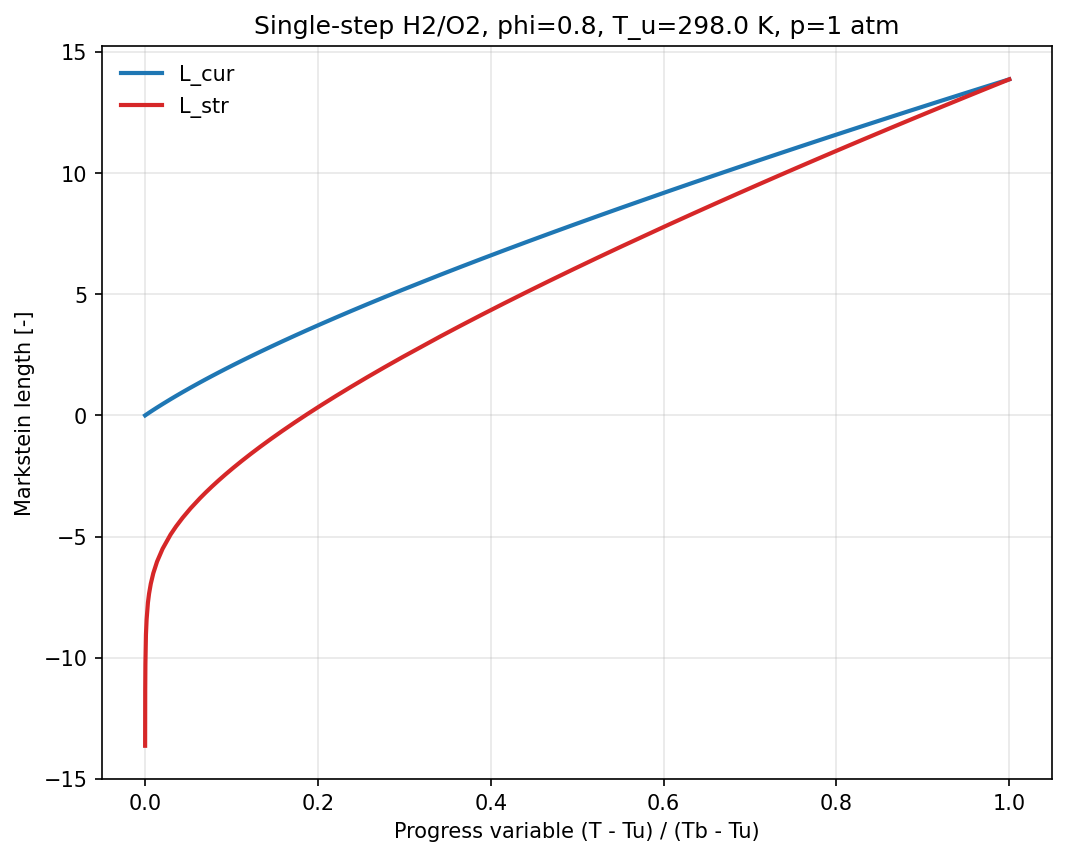

In [42]:
# Plot Markstein lengths vs progress variable
fig, ax = plt.subplots(figsize=(7.0, 5.6), dpi=150, constrained_layout=True)
ax.plot(progress, L_cur, label='L_cur', color='#1f77b4', linewidth=2.0)
ax.plot(progress, L_str, label='L_str', color='#d62728', linewidth=2.0)
ax.set_xlabel('Progress variable (T - Tu) / (Tb - Tu)')
ax.set_ylabel('Markstein length [-]')
ax.set_title(f'Single-step H2/O2, phi={PHI}, T_u={T_U} K, p=1 atm')
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.show()
